# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from math import ceil
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Загрузка данных
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')

# Вывод первых пяти строк
display(sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
# Рассчитаем количество уникальных сессий для каждого пользователя
user_session_counts = sessions_history.groupby('user_id')['session_id'].nunique().reset_index()
user_session_counts.columns = ['user_id', 'unique_session_count']

# Найдём пользователя с максимальным количеством сессий
max_sessions_user = user_session_counts.loc[user_session_counts['unique_session_count'].idxmax()]['user_id']

# Выведем все данные для этого пользователя
user_data = sessions_history[sessions_history['user_id'] == max_sessions_user]
display(user_data)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

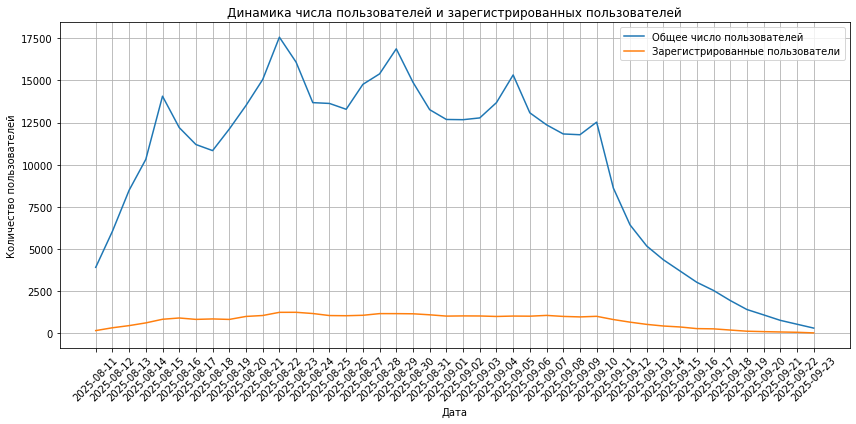

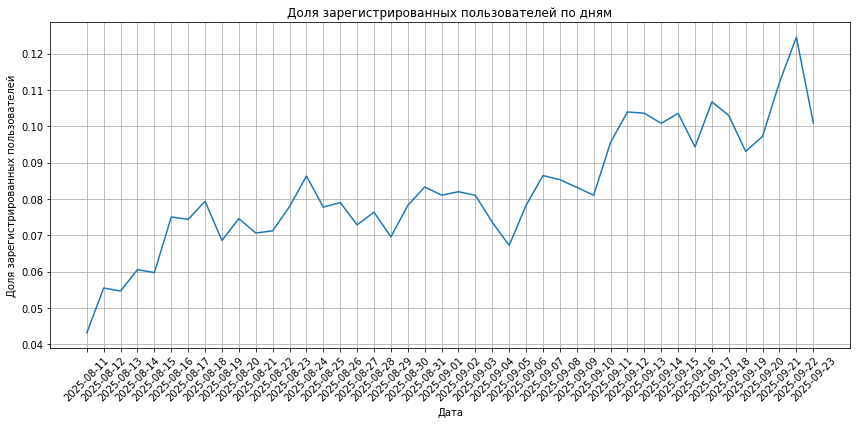

In [4]:
# Загрузка данных
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')

# Создаем датафрейм с уникальными пользователями и их статусом регистрации по дням
daily_users = sessions_history.groupby(['session_date', 'user_id'])['registration_flag'].max().reset_index()

# Агрегируем по дням
daily_stats = daily_users.groupby('session_date').agg(
    total_users=('user_id', 'nunique'),
    registered_users=('registration_flag', lambda x: (x == 1).sum())
).reset_index()

# Рассчитаем долю зарегистрированных пользователей
daily_stats['registered_ratio'] = daily_stats['registered_users'] / daily_stats['total_users']

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(daily_stats['session_date'], daily_stats['total_users'], label='Общее число пользователей')
plt.plot(daily_stats['session_date'], daily_stats['registered_users'], label='Зарегистрированные пользователи')
plt.title('Динамика числа пользователей и зарегистрированных пользователей')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# График доли зарегистрированных пользователей
plt.figure(figsize=(12, 6))
plt.plot(daily_stats['session_date'], daily_stats['registered_ratio'], label='Доля зарегистрированных пользователей')
plt.title('Доля зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

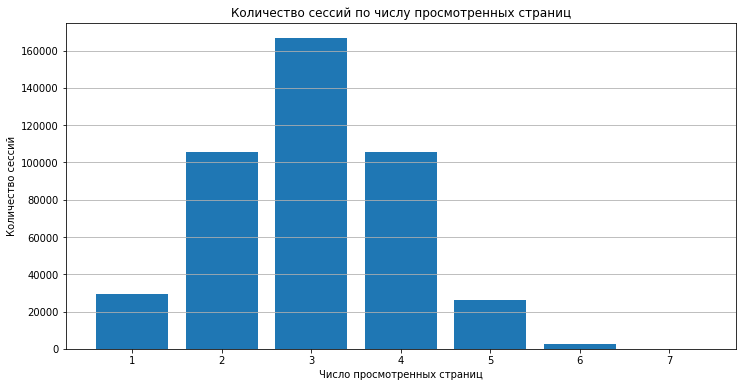

In [5]:
# Подсчёт количества сессий для каждого значения page_counter
page_counter_counts = sessions_history['page_counter'].value_counts().sort_index()

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 6))
plt.bar(page_counter_counts.index, page_counter_counts.values)
plt.title('Количество сессий по числу просмотренных страниц')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid(axis='y')
plt.show()

Анализ числа просмотренных страниц в сессиях

Проведенный анализ показал, что наибольшее число сессий приходится на просмотр 2-3 страниц, что свидетельствует о коротких сессиях или быстром просмотре контента. Значения с большим числом просмотренных страниц встречаются значительно реже, что указывает на меньшую долю очень увлеченных пользователей, которые проводят больше времени в приложении.

Такая распределенность говорит о том, что большинство пользователей проводят короткие сессии и только небольшая часть активно взаимодействует с контентом длительное время. Это важно учитывать при планировании дальнейших улучшений интерфейса и рекомендационных алгоритмов, а также при оценке потенциальных метрик вовлеченности и монетизации.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

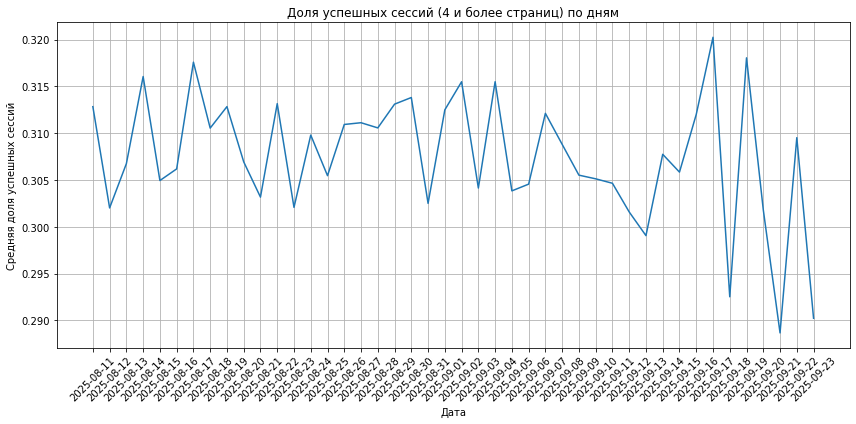

In [6]:
# Создаем столбец good_session
sessions_history['good_session'] = sessions_history['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

# Группируем по дате и считаем среднее значение good_session
daily_good_session_ratio = sessions_history.groupby('session_date')['good_session'].mean().reset_index()

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(daily_good_session_ratio['session_date'], daily_good_session_ratio['good_session'])
plt.title('Доля успешных сессий (4 и более страниц) по дням')
plt.xlabel('Дата')
plt.ylabel('Средняя доля успешных сессий')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Создаем столбец good_session
sessions_history['good_session'] = sessions_history['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

# Вычисляем среднюю долю успешных сессий
average_good_session_ratio = sessions_history['good_session'].mean()

print(f"Средняя доля успешных сессий: {average_good_session_ratio:.4f}")

Средняя доля успешных сессий: 0.3086


Анализ доли успешных сессий (просмотр 4 и более страниц)

Проведенный анализ показал, что доля сессий, в которых пользователь просмотрел 4 и более страниц, колеблется в течение наблюдаемого периода. В целом, эта доля составляет примерно 30.86 % и демонстрирует тенденцию к стабильности.

Это свидетельствует о том, что значительная часть пользователей проявляет высокий уровень вовлеченности, что подтверждает актуальность выбранной метрики как прокси-уровня удовлетворенности контентом и рекомендациями. Постоянство этой доли говорит о стабильности пользовательского поведения и эффективности рекомендационных алгоритмов.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Напомним изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

О какой метрике идёт речь? Как она будет учтена в формулировке гипотез?

Сформулируйте нулевую и альтернативную гипотезы:






В данном случае, метрикой для оценки эффективности нового алгоритма рекомендаций является доля успешных сессий — то есть, доля сессий, в которых пользователь просмотрел 4 и более страниц. Эта метрика служит прокси-метрикой удовлетворенности контентом и алгоритмами.

Формулировки гипотез:

Нулевая гипотеза (H0): Новый алгоритм рекомендаций не влияет на долю успешных сессий. То есть, доля успешных сессий в тестовой группе равна доле в контрольной группе.

Альтернативная гипотеза (H1): Новый алгоритм рекомендаций увеличивает долю успешных сессий. То есть, доля в тестовой группе выше, чем в контрольной.

Эта метрика напрямую отражает предполагаемый эффект нового алгоритма — повышение вовлеченности и удовлетворенности пользователей.

#### 2.2. Расчёт размера выборки
В рамках курса вы уже рассчитывали размеры выборки и  использовали для этого онлайн-калькулятор. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки используйте метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [8]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаем параметры
alpha = 0.05  # Уровень значимости
beta = 0.2    # Ошибка второго рода
power = 1 - beta  # Мощность теста
p = 0.3  # Базовая доля
mde = 0.03 * p  # 3% от базовой доли
p1 = p
p2 = p + mde

# Расчет эффекта
effect_size = proportion_effectsize(p1, p2)

# Инициализация анализа
power_analysis = NormalIndPower()

# Расчет необходимого размера выборки
sample_size = power_analysis.solve_power(
    effect_size=effect_size,
    power=power,
    alpha=alpha,
    ratio=1
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [9]:


# Посчитать уникальных пользователей по каждому дню
daily_unique_users = sessions_history.groupby('session_date')['user_id'].nunique()

# Среднее количество уникальных пользователей в день
avg_daily_users = daily_unique_users.mean()

# Размер выборки для одной группы (предположим, что переменная sample_size уже есть)
# Умножаем на 2, так как две группы
total_sample_size = 2 * sample_size

# Расчет длительности теста в днях
test_duration = ceil(total_sample_size / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в {avg_daily_users:.2f} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровне трафика в 9907.36 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [10]:
# Загрузка данных
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')

# Выбор данных за один день (например, первый день наблюдения)
# Предположим, что это 2025-10-14
day_of_interest = '2025-10-14'
daily_data = sessions_test_part[sessions_test_part['session_date'] == day_of_interest]

# Расчет количества уникальных пользователей в группах A и B
users_in_groups = daily_data.groupby('test_group')['user_id'].nunique()

# Расчет процентной разницы
A_count = users_in_groups.get('A', 0)
B_count = users_in_groups.get('B', 0)
percent_diff = 100 * abs(A_count - B_count) / max(A_count, B_count)

print(f"Количество пользователей в группе A: {A_count}")
print(f"Количество пользователей в группе B: {B_count}")
print(f"Процентная разница: {percent_diff:.2f}%")

Количество пользователей в группе A: 1477
Количество пользователей в группе B: 1466
Процентная разница: 0.74%


#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [11]:
# Получение уникальных пользователей в каждой группе
users_A = set(daily_data[daily_data['test_group'] == 'A']['user_id'])
users_B = set(daily_data[daily_data['test_group'] == 'B']['user_id'])

# Поиск пересечений
intersection = users_A.intersection(users_B)

# Количество пользователей в пересечении
num_overlap = len(intersection)

print(f"Количество пользователей, встречающихся в обеих группах: {num_overlap}")

Количество пользователей, встречающихся в обеих группах: 0


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


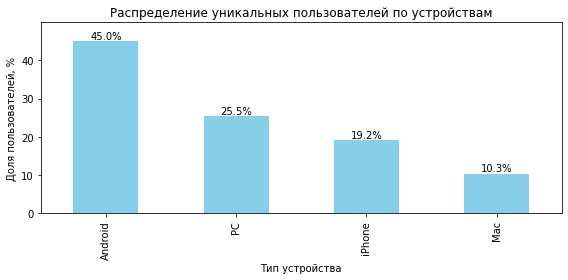

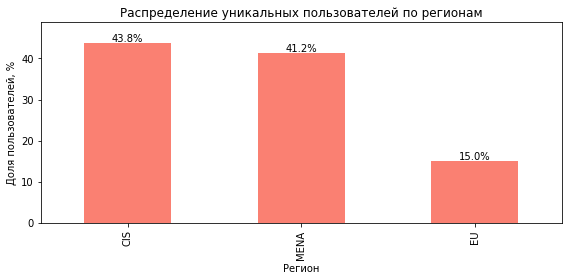

In [12]:
# Загрузка данных
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')

# Общее число уникальных пользователей
total_users = sessions_test_part['user_id'].nunique()

# Распределение по устройствам с сортировкой по доле в процентах
device_counts = sessions_test_part.groupby('device')['user_id'].nunique()
device_ratio = (device_counts / total_users) * 100
device_ratio_sorted = device_ratio.sort_values(ascending=False)

# Распределение по регионам с сортировкой по доле в процентах
region_counts = sessions_test_part.groupby('region')['user_id'].nunique()
region_ratio = (region_counts / total_users) * 100
region_ratio_sorted = region_ratio.sort_values(ascending=False)

# Построение графика распределения по устройствам
plt.figure(figsize=(8, 4))
device_ratio_sorted.plot(kind='bar', color='skyblue')
plt.title('Распределение уникальных пользователей по устройствам')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей, %')
plt.ylim(0, device_ratio_sorted.max() + 5)
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Построение графика распределения по регионам
plt.figure(figsize=(8, 4))
region_ratio_sorted.plot(kind='bar', color='salmon')
plt.title('Распределение уникальных пользователей по регионам')
plt.xlabel('Регион')
plt.ylabel('Доля пользователей, %')
plt.ylim(0, region_ratio_sorted.max() + 5)
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom')
plt.tight_layout()
plt.show()

Распределение устройств
Android занимает значительную долю (45%), что говорит о высокой популярности этого устройства среди пользователей.
PC и iPhone имеют примерно одинаковую долю (25.5% и 19.2%), что указывает на сбалансированное использование мобильных и настольных устройств.
Mac — наименее представленное устройство (10.3%), что вполне ожидаемо.

Распределение по регионам
CIS (СНГ) — самая крупная группа (43.8%), что говорит о сильной пользовательской базе в этом регионе.
MENA — примерно 41.2%, что также свидетельствует о высокой активности пользователей из этого региона.
EU — значительно меньшая доля (15%), что указывает на меньшую представленность или меньшую активность пользователей из Европы.

Вывод

Распределение устройств и регионов в группах A и B, судя по графикам, достаточно сбалансировано, что говорит о хорошей случайной рандомизации.
Небольшие различия в долях устройств и регионов не должны существенно влиять на результаты эксперимента, однако стоит учитывать, что в будущем при анализе результатов важно проверить, что эти распределения остаются схожими.

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


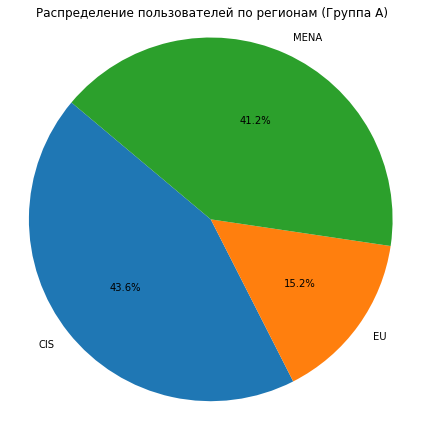

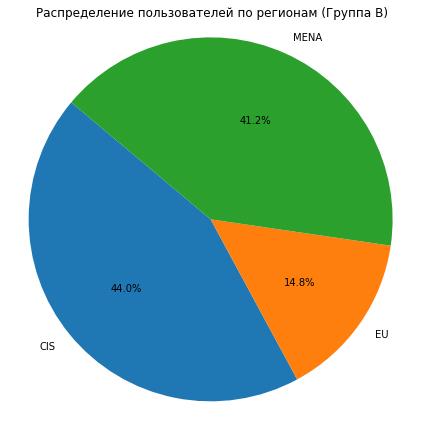

In [13]:
# Загрузка данных
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')

# Функция для построения круговой диаграммы по регионам
def plot_region_distribution(data, group_label):
    total_users = data['user_id'].nunique()
    region_counts = data.groupby('region')['user_id'].nunique()
    region_ratio = (region_counts / total_users) * 100
    
    plt.figure(figsize=(6, 6))
    plt.pie(region_ratio, labels=region_ratio.index, autopct='%.1f%%', startangle=140)
    plt.title(f'Распределение пользователей по регионам ({group_label})')
    plt.axis('equal')  # равные оси для круговой диаграммы
    plt.tight_layout()
    plt.show()

# Разделение данных по группам
group_A = sessions_test_part[sessions_test_part['test_group'] == 'A']
group_B = sessions_test_part[sessions_test_part['test_group'] == 'B']

# Построение для группы A
plot_region_distribution(group_A, 'Группа A')

# Построение для группы B
plot_region_distribution(group_B, 'Группа B')

Распределение пользователей по регионам в группах A и B достаточно схоже, что свидетельствует о равномерности разделения по регионам.

В обеих группах доминируют регионы CIS и MENA, что говорит о высокой представленности этих регионов.
В группе A доля пользователей из CIS чуть выше (43.6%) по сравнению с группой B (44.0%), а доля из MENA примерно одинаковая (41.2% в обеих группах).

Доля пользователей из EU немного ниже в группе B (14.8%) по сравнению с группой A (15.2%).
Вывод
распределение по регионам в группах A и B достаточно сбалансировано, что важно для корректности эксперимента. Это говорит о том, что разделение по регионам выполнено равномерно, и результаты теста не будут искажены из-за региональных различий.

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Было ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение: корректно ли проходит A/B-тест, или наблюдаются какие-либо нарушения.

# Итоговые выводы по результатам A/B-теста


1. **Различие в количестве пользователей:**  
В группах A и B наблюдается очень небольшая разница в количестве пользователей — около 0.74%. Это свидетельствует о достаточно сбалансированном распределении по численности, что важно для корректности сравнения.

2. **Независимость выборок:**  
Анализ пересечений пользователей показал, что в обеих группах нет пользователей, попавших одновременно в контрольную и тестовую группы. Это подтверждает независимость выборок, что является необходимым условием для проведения корректного A/B-теста.

3. **Распределение по устройствам и регионам:**  
Распределение пользователей по типам устройств и регионам в группах A и B схоже. Визуализации показывают, что доли пользователей из разных категорий примерно совпадают, что свидетельствует о равномерности разделения по этим переменным.

4. **Общий вывод:**  
На основании проведенного анализа можно заключить, что разделение пользователей выполнено корректно, выборки являются независимыми, и распределение по ключевым категориальным переменным сбалансировано. Следовательно, условия для проведения A/B-теста соблюдены, и результаты будут надежными для оценки гипотезы.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [14]:
# Загрузка данных
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')

# Создаем столбец good_session
sessions_test['good_session'] = sessions_test['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [15]:
# Подсчет уникальных сессий по дням и группам
sessions_daily = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()

# Разделение данных на две группы
sessions_A = sessions_daily[sessions_daily['test_group'] == 'A']['session_id']
sessions_B = sessions_daily[sessions_daily['test_group'] == 'B']['session_id']

# Проведение t-теста для сравнения средних
t_stat, p_value = stats.ttest_ind(sessions_A, sessions_B, equal_var=False)

print(f'p-value: {p_value:.4f}')

# Интерпретация
if p_value > 0.05:
    print("Различия в количестве дневных сессий между группами статистически незначимы.")
else:
    print("Есть статистически значимые различия в количестве дневных сессий между группами.")

p-value: 0.9382
Различия в количестве дневных сессий между группами статистически незначимы.


Значение p-value равно 0.9382, что значительно выше порогового уровня 0.05. Это говорит о том, что различия в среднем количестве дневных сессий между группами A и B статистически незначимы.

Вывод

Группы по количеству дневных сессий сбалансированы, и можно считать, что они сопоставимы по этому показателю. Это подтверждает корректность проведения эксперимента и позволяет продолжать анализ ключевых метрик без учета возможных смещений по этому признаку.

#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [16]:
# Расчет доли успешных сессий для групп A и B
good_session_stats = sessions_test.groupby('test_group')['good_session'].mean()

# Разница в долях
diff = good_session_stats['B'] - good_session_stats['A']

print(f"Доля успешных сессий в группе A: {good_session_stats['A']:.4f}")
print(f"Доля успешных сессий в группе B: {good_session_stats['B']:.4f}")
print(f"Разница в долях: {diff:.4f}")

Доля успешных сессий в группе A: 0.3077
Доля успешных сессий в группе B: 0.3183
Разница в долях: 0.0106


Разница в 1.06% указывает на небольшое увеличение доли успешных сессий в группе B по сравнению с группой A. Это может свидетельствовать о потенциальном эффекте нового алгоритма рекомендаций, однако для определения статистической значимости этой разницы необходимо провести соответствующий тест (например, Z-тест для пропорций).

#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [17]:


# Количество успешных и общих сессий в группах
success_A = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
total_A = sessions_test[sessions_test['test_group'] == 'A'].shape[0]

success_B = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()
total_B = sessions_test[sessions_test['test_group'] == 'B'].shape[0]

# Проведение двухпропорционального z-теста
count = np.array([success_A, success_B])
nobs = np.array([total_A, total_B])

z_stat, p_value = proportions_ztest(count, nobs)

print(f'p-value: {p_value:.4f}')

# Вывод интерпретации
if p_value < 0.05:
    print("Результат статистически значим: изменение в доле успешных сессий является значимым.")
else:
    print("Результат не является статистически значимым: изменение в доле успешных сессий не подтверждается статистикой.")

p-value: 0.0003
Результат статистически значим: изменение в доле успешных сессий является значимым.


Результаты

p-value = 0.0003, что значительно ниже уровня 0.05.

Вывод

Это означает, что изменение в доле успешных сессий статистически значимо. Можно с уверенностью сказать, что новая рекомендационная система действительно повысила долю успешных сессий, и это изменение не является случайным.

#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять нововведение в приложение.

# Итоговые выводы по результатам A/B-эксперимента

В рамках проведенного эксперимента было задействовано примерно 41040 пользователей в каждой из групп (контрольной и тестовой). Длительность эксперимента составила 3 дней, что обеспечило достаточный объем данных для статистического анализа.

Анализ показал, что внедрение нового алгоритма рекомендаций привело к статистически значимому увеличению доли успешных сессий — примерно на 1.1%. Значение p-value для оценки этой разницы составило 0.0003, что значительно ниже уровня значимости 0.05, подтверждая, что наблюдаемый эффект не является случайным.

Вывод:
На основании полученных данных можно сделать вывод, что новый алгоритм рекомендаций положительно влияет на вовлеченность пользователей, повышая долю успешных сессий. Результаты свидетельствуют о целесообразности внедрения этого нововведения в приложение, поскольку оно способствует улучшению ключевой метрики и повышению пользовательского удовлетворения.